# 전체 자치구 사용

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
import shap

In [ ]:
df = pd.read_csv("data/seoul_preprocessed.csv")
print(df.shape)

(44090, 31)


In [3]:
test_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(index=test_df.index)

In [4]:
# test를 제외한 데이터로 risk level 추출
df_nonzero = train_df[train_df['tow_count'] > 0]

# `tow_count` 값으로 정렬
df_nonzero = df_nonzero.sort_values(by='tow_count')

total_nonzero = len(df_nonzero)

mid_end = int(total_nonzero*1/2) # 절반

# 각 구간 끝값 (경계)
mid_end_value = df_nonzero.iloc[mid_end - 1]['tow_count']  # 가운데 구간 끝값

print(f"가운데 구간 끝값: {mid_end_value}\n")


train_df['risk_level'] = train_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)

test_df['risk_level'] = test_df['tow_count'].apply(
    lambda x: 0 if x == 0 else (1 if x <= mid_end_value else 2)
)


# 결과 확인
print(train_df[['tow_count', 'risk_level']].tail())

가운데 구간 끝값: 2

       tow_count  risk_level
44085          0           0
44086          0           0
44087          0           0
44088          0           0
44089          0           0


In [5]:
features = train_df.columns[3:-2]
target = 'risk_level'
del train_df['tow_count']
del test_df['tow_count']

# 테스트 데이터 준비
train = train_df.iloc[:,3:]
X_test, y_test   = test_df[features], test_df[target]

In [6]:
exp_clf = setup(data = train, target = target, session_id=42)

,Description,Value
0,Session id,42
1,Target,risk_level
2,Target type,Multiclass
3,Original data shape,"(35272, 28)"
4,Transformed data shape,"(35272, 28)"
5,Transformed train set shape,"(24690, 28)"
6,Transformed test set shape,"(10582, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model = compare_models()

# XGBoost

In [9]:
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7999,0.7994,0.7999,0.7341,0.7420,0.1395,0.1877
1,0.7934,0.7840,0.7934,0.7070,0.7338,0.1221,0.1602
2,0.7959,0.7904,0.7959,0.7259,0.7413,0.1438,0.1828
3,0.7991,0.8125,0.7991,0.7221,0.7352,0.1184,0.1698
4,0.7959,0.7762,0.7959,0.7148,0.7343,0.1201,0.1633
5,0.7975,0.7945,0.7975,0.7182,0.7351,0.1200,0.1670
6,0.8011,0.7827,0.8011,0.7306,0.7391,0.1332,0.1876
7,0.7999,0.7990,0.7999,0.7301,0.7446,0.1596,0.2046
8,0.7983,0.7815,0.7983,0.7335,0.7432,0.1477,0.1916


In [10]:
tuned_xgb = tune_model(xgb, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7995,0.7958,0.7995,0.7295,0.7441,0.1589,0.2026
1,0.7926,0.7784,0.7926,0.7195,0.7392,0.1420,0.1761
2,0.7971,0.7931,0.7971,0.7275,0.7450,0.1631,0.2009
3,0.7975,0.8024,0.7975,0.7238,0.7403,0.1440,0.1868
4,0.7902,0.7870,0.7902,0.7007,0.7289,0.1055,0.1396
5,0.7987,0.7868,0.7987,0.7295,0.7403,0.1381,0.1849
6,0.7971,0.7795,0.7971,0.7259,0.7388,0.1322,0.1765
7,0.7959,0.7980,0.7959,0.7235,0.7419,0.1531,0.1911
8,0.7999,0.7808,0.7999,0.7323,0.7468,0.1691,0.2116


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [11]:
final_model = finalize_model(tuned_xgb)
prediction = predict_model(final_model, data = X_test)

In [12]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, prediction['prediction_label'], average ="weighted")
print(f"f1_score: {f1:.4f}")

f1_score: 0.7424


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 계산
cm = confusion_matrix(y_test, prediction['prediction_label'])

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

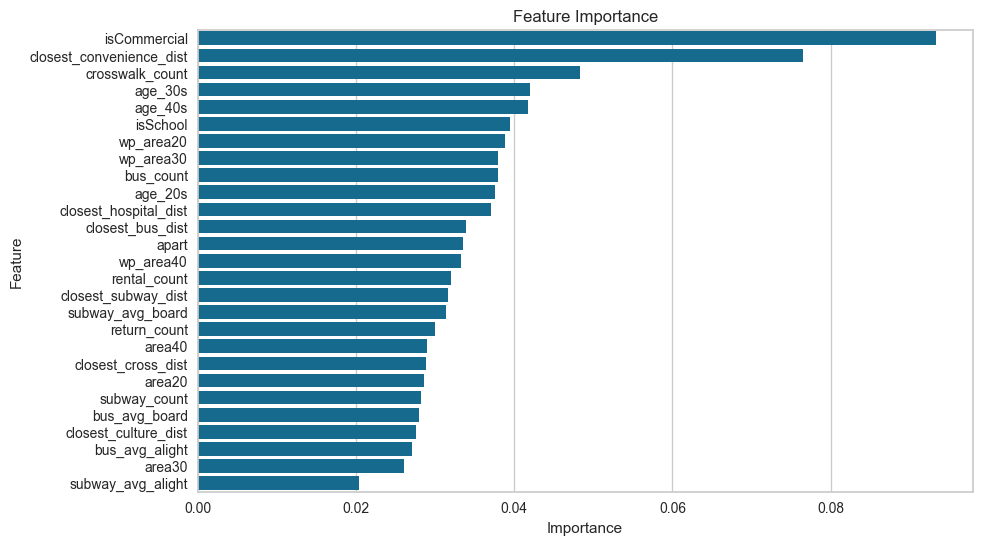

In [14]:
model_feature_importance = final_model.feature_importances_

# 중요도 값과 feature 이름을 함께 출력
features = get_config('X_train').columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': model_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

클래스 0


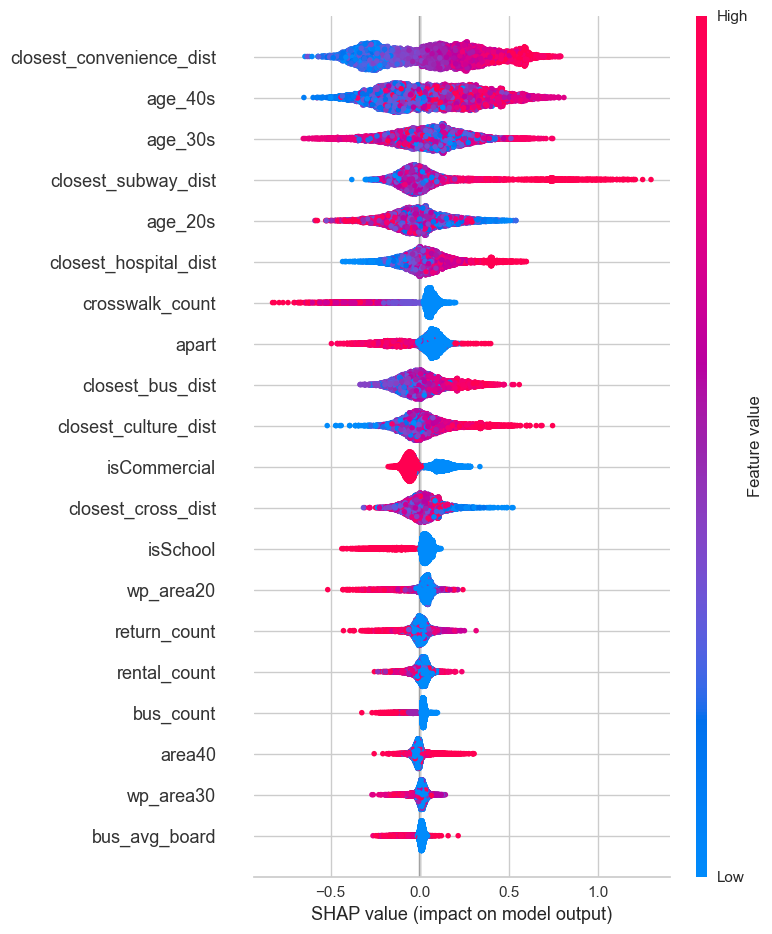

클래스 1


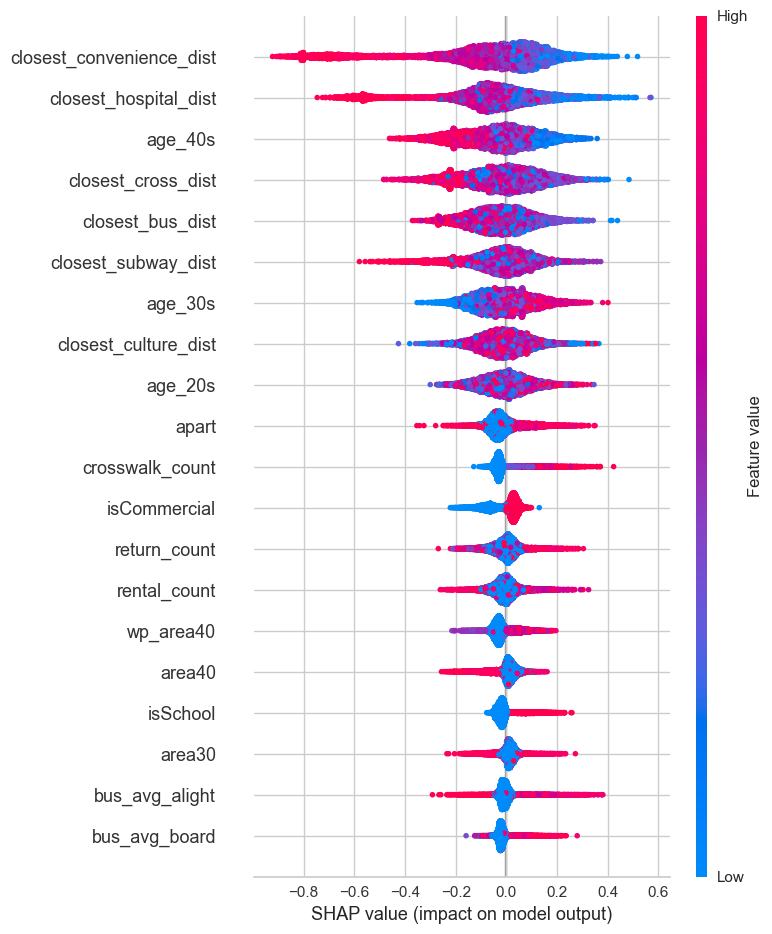

클래스 2


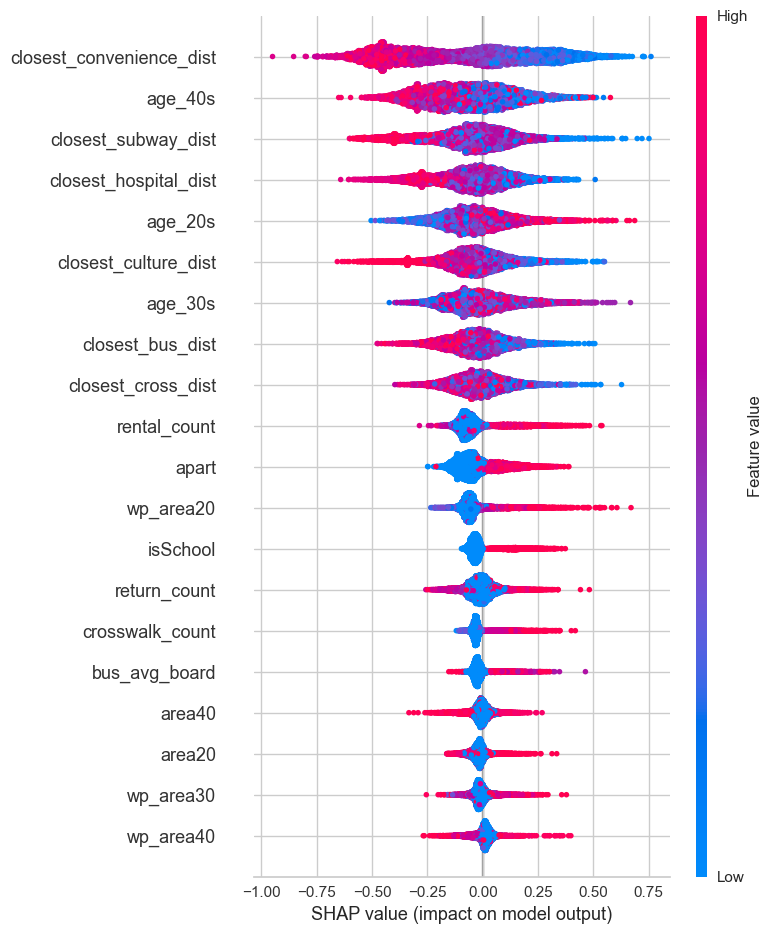

In [15]:
X_test_transformed = final_model[:-1].transform(X_test)

explainer = shap.Explainer(final_model.steps[-1][1])
shap_values = explainer(X_test_transformed)

for class_idx in range(shap_values.values.shape[2]):
    print(f"클래스 {class_idx}")
    plt.figure(figsize=(8, 4))
    shap.summary_plot(shap_values.values[:, :, class_idx], X_test_transformed)

# LightGBM

In [19]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8028,0.8065,0.8028,0.7239,0.7332,0.1042,0.1693
1,0.7999,0.7875,0.7999,0.7249,0.7338,0.1065,0.1616
2,0.8019,0.7987,0.8019,0.7231,0.7327,0.1006,0.1634
3,0.8015,0.8165,0.8015,0.7319,0.7310,0.0933,0.1574
4,0.8015,0.7826,0.8015,0.7210,0.7308,0.0945,0.1585
5,0.7979,0.7975,0.7979,0.7117,0.7254,0.0740,0.1265
6,0.7959,0.7864,0.7959,0.7106,0.7273,0.0839,0.1306
7,0.8036,0.8081,0.8036,0.7328,0.7348,0.1097,0.1785
8,0.7999,0.7897,0.7999,0.7299,0.7291,0.0823,0.1418


In [20]:
tuned_lgbm = tune_model(lgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7882,0.7813,0.7882,0.7222,0.7431,0.1684,0.1930
1,0.7857,0.7625,0.7857,0.7213,0.7425,0.1660,0.1881
2,0.7874,0.7793,0.7874,0.7263,0.7457,0.1771,0.1992
3,0.7979,0.7892,0.7979,0.7348,0.7523,0.1995,0.2316
4,0.7914,0.7667,0.7914,0.7264,0.7453,0.1723,0.2002
5,0.7841,0.7711,0.7841,0.7141,0.7375,0.1475,0.1704
6,0.7833,0.7723,0.7833,0.7197,0.7393,0.1542,0.1759
7,0.7837,0.7842,0.7837,0.7155,0.7393,0.1602,0.1814
8,0.7825,0.7696,0.7825,0.7224,0.7429,0.1724,0.1910


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [21]:
final_model = finalize_model(tuned_lgbm)
prediction = predict_model(final_model, data = X_test)

f1 = f1_score(y_test, prediction['prediction_label'], average ="weighted")
print(f"f1_score: {f1:.4f}")

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
f1_score: 0.7403


In [ ]:
# 혼동 행렬 계산
cm = confusion_matrix(y_test, prediction['prediction_label'])

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

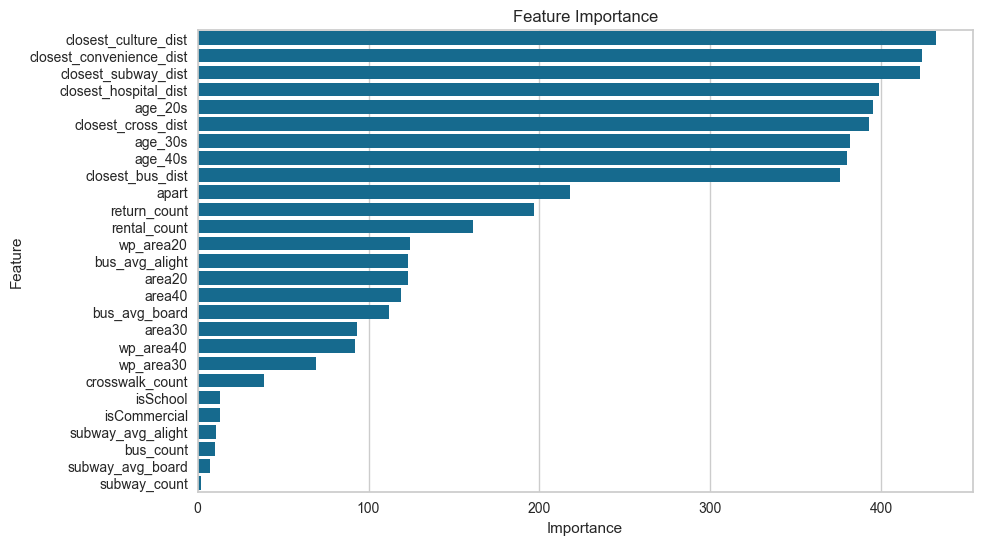

In [23]:
model_feature_importance = final_model.feature_importances_

# 중요도 값과 feature 이름을 함께 출력
features = get_config('X_train').columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': model_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

클래스 0


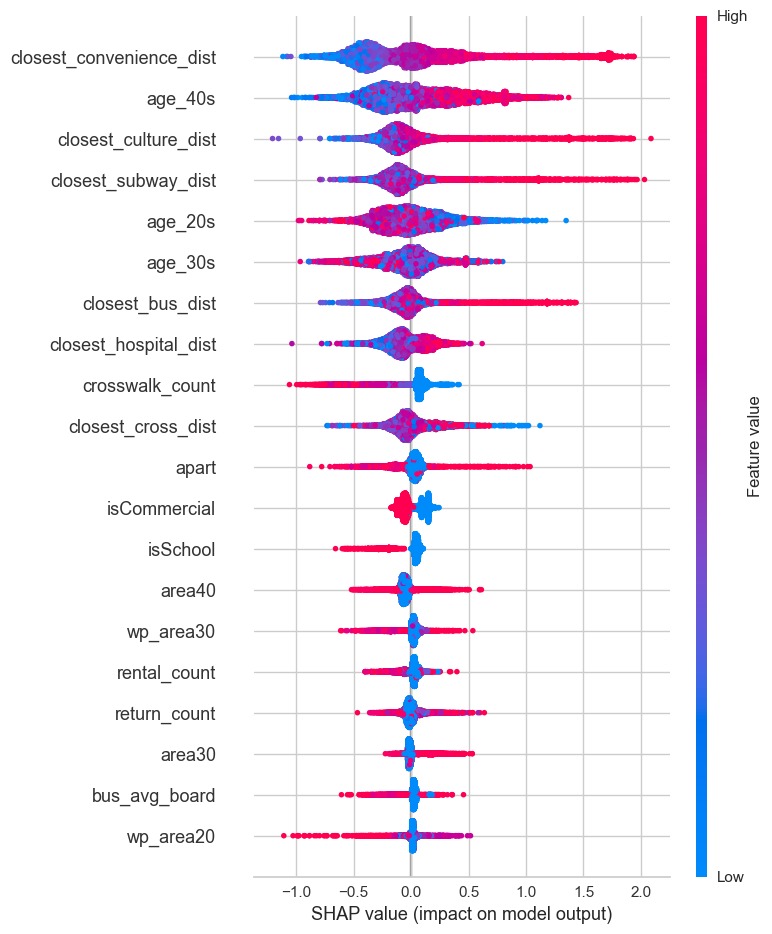

클래스 1


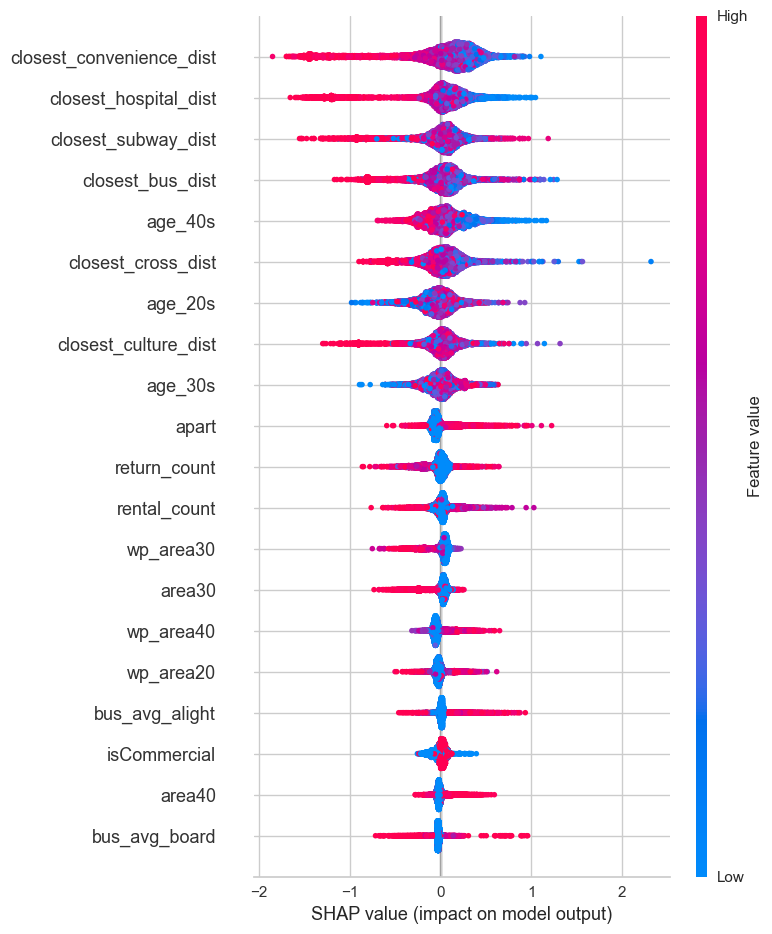

클래스 2


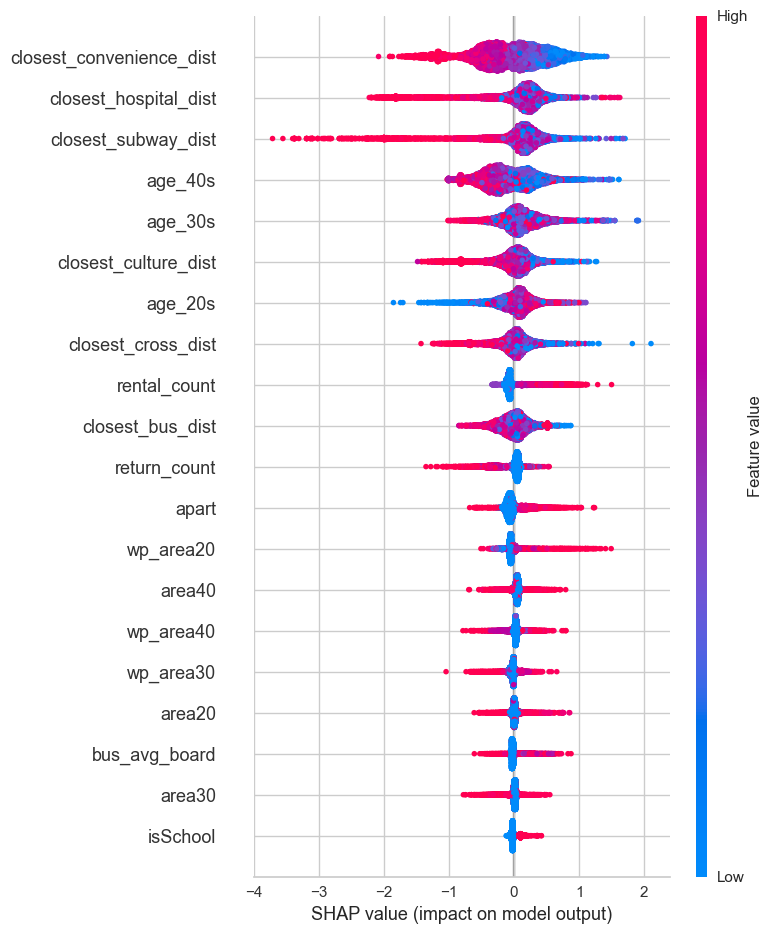

In [24]:
X_test_transformed = final_model[:-1].transform(X_test)

explainer = shap.Explainer(final_model.steps[-1][1])
shap_values = explainer(X_test_transformed)

for class_idx in range(shap_values.values.shape[2]):
    print(f"클래스 {class_idx}")
    plt.figure(figsize=(8, 4))
    shap.summary_plot(shap_values.values[:, :, class_idx], X_test_transformed)

# Extra Trees Classifier	

In [26]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7967,0.7684,0.7967,0.7105,0.7231,0.0605,0.1072
1,0.7963,0.7355,0.7963,0.7013,0.7213,0.0517,0.0962
2,0.8003,0.7513,0.8003,0.7126,0.7246,0.0643,0.1255
3,0.7951,0.7676,0.7951,0.6941,0.7192,0.0511,0.0927
4,0.7951,0.7444,0.7951,0.6896,0.7161,0.0350,0.0720
5,0.7955,0.7458,0.7955,0.7079,0.7229,0.0627,0.1071
6,0.7995,0.7549,0.7995,0.7140,0.7264,0.0779,0.1362
7,0.7975,0.7734,0.7975,0.7106,0.7234,0.0636,0.1145
8,0.7975,0.7554,0.7975,0.7141,0.7231,0.0578,0.1087


In [27]:
tuned_et = tune_model(et, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7991,0.7608,0.7991,0.6386,0.7099,0.0000,0.0000
1,0.7991,0.7344,0.7991,0.6386,0.7099,0.0000,0.0000
2,0.7991,0.7384,0.7991,0.6386,0.7099,0.0000,0.0000
3,0.7987,0.7667,0.7987,0.6379,0.7093,0.0000,0.0000
4,0.7987,0.7226,0.7987,0.6379,0.7093,0.0000,0.0000
5,0.7987,0.7282,0.7987,0.6379,0.7093,0.0000,0.0000
6,0.7987,0.7446,0.7987,0.6379,0.7093,0.0000,0.0000
7,0.7987,0.7579,0.7987,0.6379,0.7093,0.0000,0.0000
8,0.7987,0.7393,0.7987,0.6379,0.7093,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [28]:
final_model = finalize_model(tuned_et)
prediction = predict_model(final_model, data = X_test)

f1 = f1_score(y_test, prediction['prediction_label'], average ="weighted")
print(f"f1_score: {f1:.4f}")

f1_score: 0.7215


In [ ]:
# 혼동 행렬 계산
cm = confusion_matrix(y_test, prediction['prediction_label'])

# 혼동 행렬 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

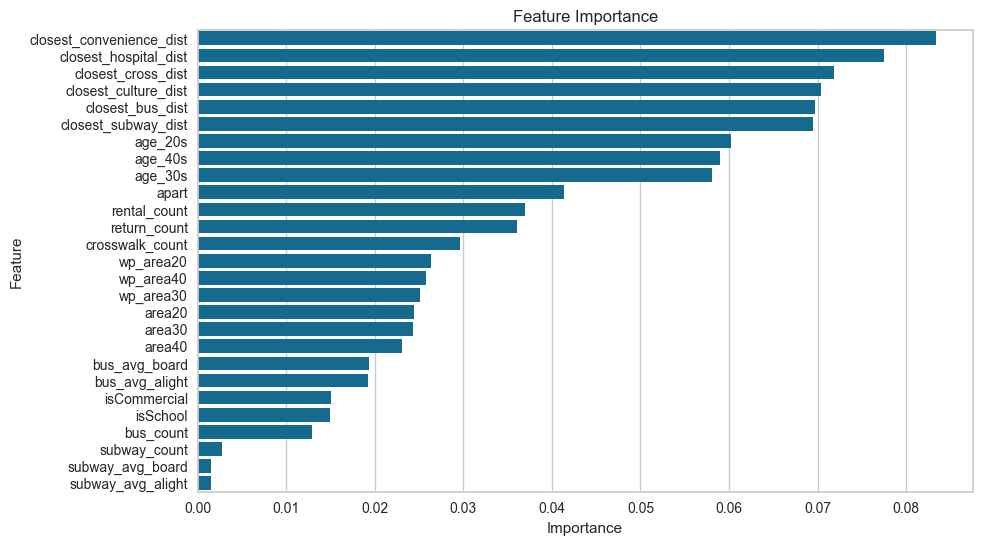

In [30]:
model_feature_importance = final_model.feature_importances_

# 중요도 값과 feature 이름을 함께 출력
features = get_config('X_train').columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': model_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# RandomForest

In [41]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8015,0.7773,0.8015,0.7412,0.7207,0.0431,0.1127
1,0.7991,0.7483,0.7991,0.6957,0.7188,0.0410,0.0948
2,0.8007,0.7646,0.8007,0.7196,0.7225,0.0538,0.1175
3,0.8007,0.7782,0.8007,0.7251,0.7206,0.0489,0.1149
4,0.7983,0.7454,0.7983,0.6963,0.7165,0.0346,0.0841
5,0.7975,0.7546,0.7975,0.6955,0.7153,0.0293,0.0724
6,0.7991,0.7539,0.7991,0.7264,0.7198,0.0439,0.1000
7,0.7987,0.7811,0.7987,0.7137,0.7186,0.0380,0.0907
8,0.7995,0.7595,0.7995,0.7100,0.7206,0.0485,0.1075


In [42]:
tuned_rf = tune_model(rf, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7999,0.7804,0.7999,0.7233,0.7118,0.0069,0.0591
1,0.7991,0.7482,0.7991,0.6386,0.7099,0.0000,0.0000
2,0.7991,0.7533,0.7991,0.6386,0.7099,0.0000,0.0000
3,0.7987,0.7756,0.7987,0.6382,0.7095,0.0014,0.0174
4,0.7987,0.7418,0.7987,0.6379,0.7093,0.0000,0.0000
5,0.7987,0.7472,0.7987,0.6379,0.7093,0.0000,0.0000
6,0.7987,0.7548,0.7987,0.6379,0.7093,0.0000,0.0000
7,0.7987,0.7763,0.7987,0.6379,0.7093,0.0000,0.0000
8,0.7987,0.7515,0.7987,0.6379,0.7093,0.0000,0.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


# Soft Voting

In [ ]:
import numpy as np
xgb_model = finalize_model(tuned_xgb)
lgbm_model = finalize_model(tuned_lgbm)
et_model = finalize_model(tuned_et)
rf_model = finalize_model(tuned_rf)

pred_xgb = xgb_model.predict_proba(X_test)
pred_lgbm = lgbm_model.predict_proba(X_test)
pred_et = et_model.predict_proba(X_test)
pred_rf = rf_model.predict_proba(X_test)

average_pred = np.mean([pred_xgb, pred_lgbm], axis=0)  # pred_xgb, pred_lgbm, pred_et, pred_rf

# 최종 예측: 확률이 가장 높은 클래스 선택
final_preds = np.argmax(average_pred, axis=1)

f1 = f1_score(y_test, final_preds, average='weighted')
print(f"Soft Voting F1 Score: {f1:.4f}")

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Soft Voting F1 Score: 0.7432
